In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torchsummary import summary
import pandas as pd
import time

In [2]:
#define a simple ANN.
class ANNModel(nn.Module):
    def __init__(self, input_size):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Hidden layer 1
        self.fc2 = nn.Linear(128, 128)         # Hidden layer 2
        self.fc3 = nn.Linear(128, 128)         # Hidden layer 3
        self.fc4 = nn.Linear(128, 1)           # Output layer
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)
#model = ANNModel(X_train.shape[1])
#model.cuda()
#summary(model,input_size=(1,X_train.shape[1]))
#print(model)

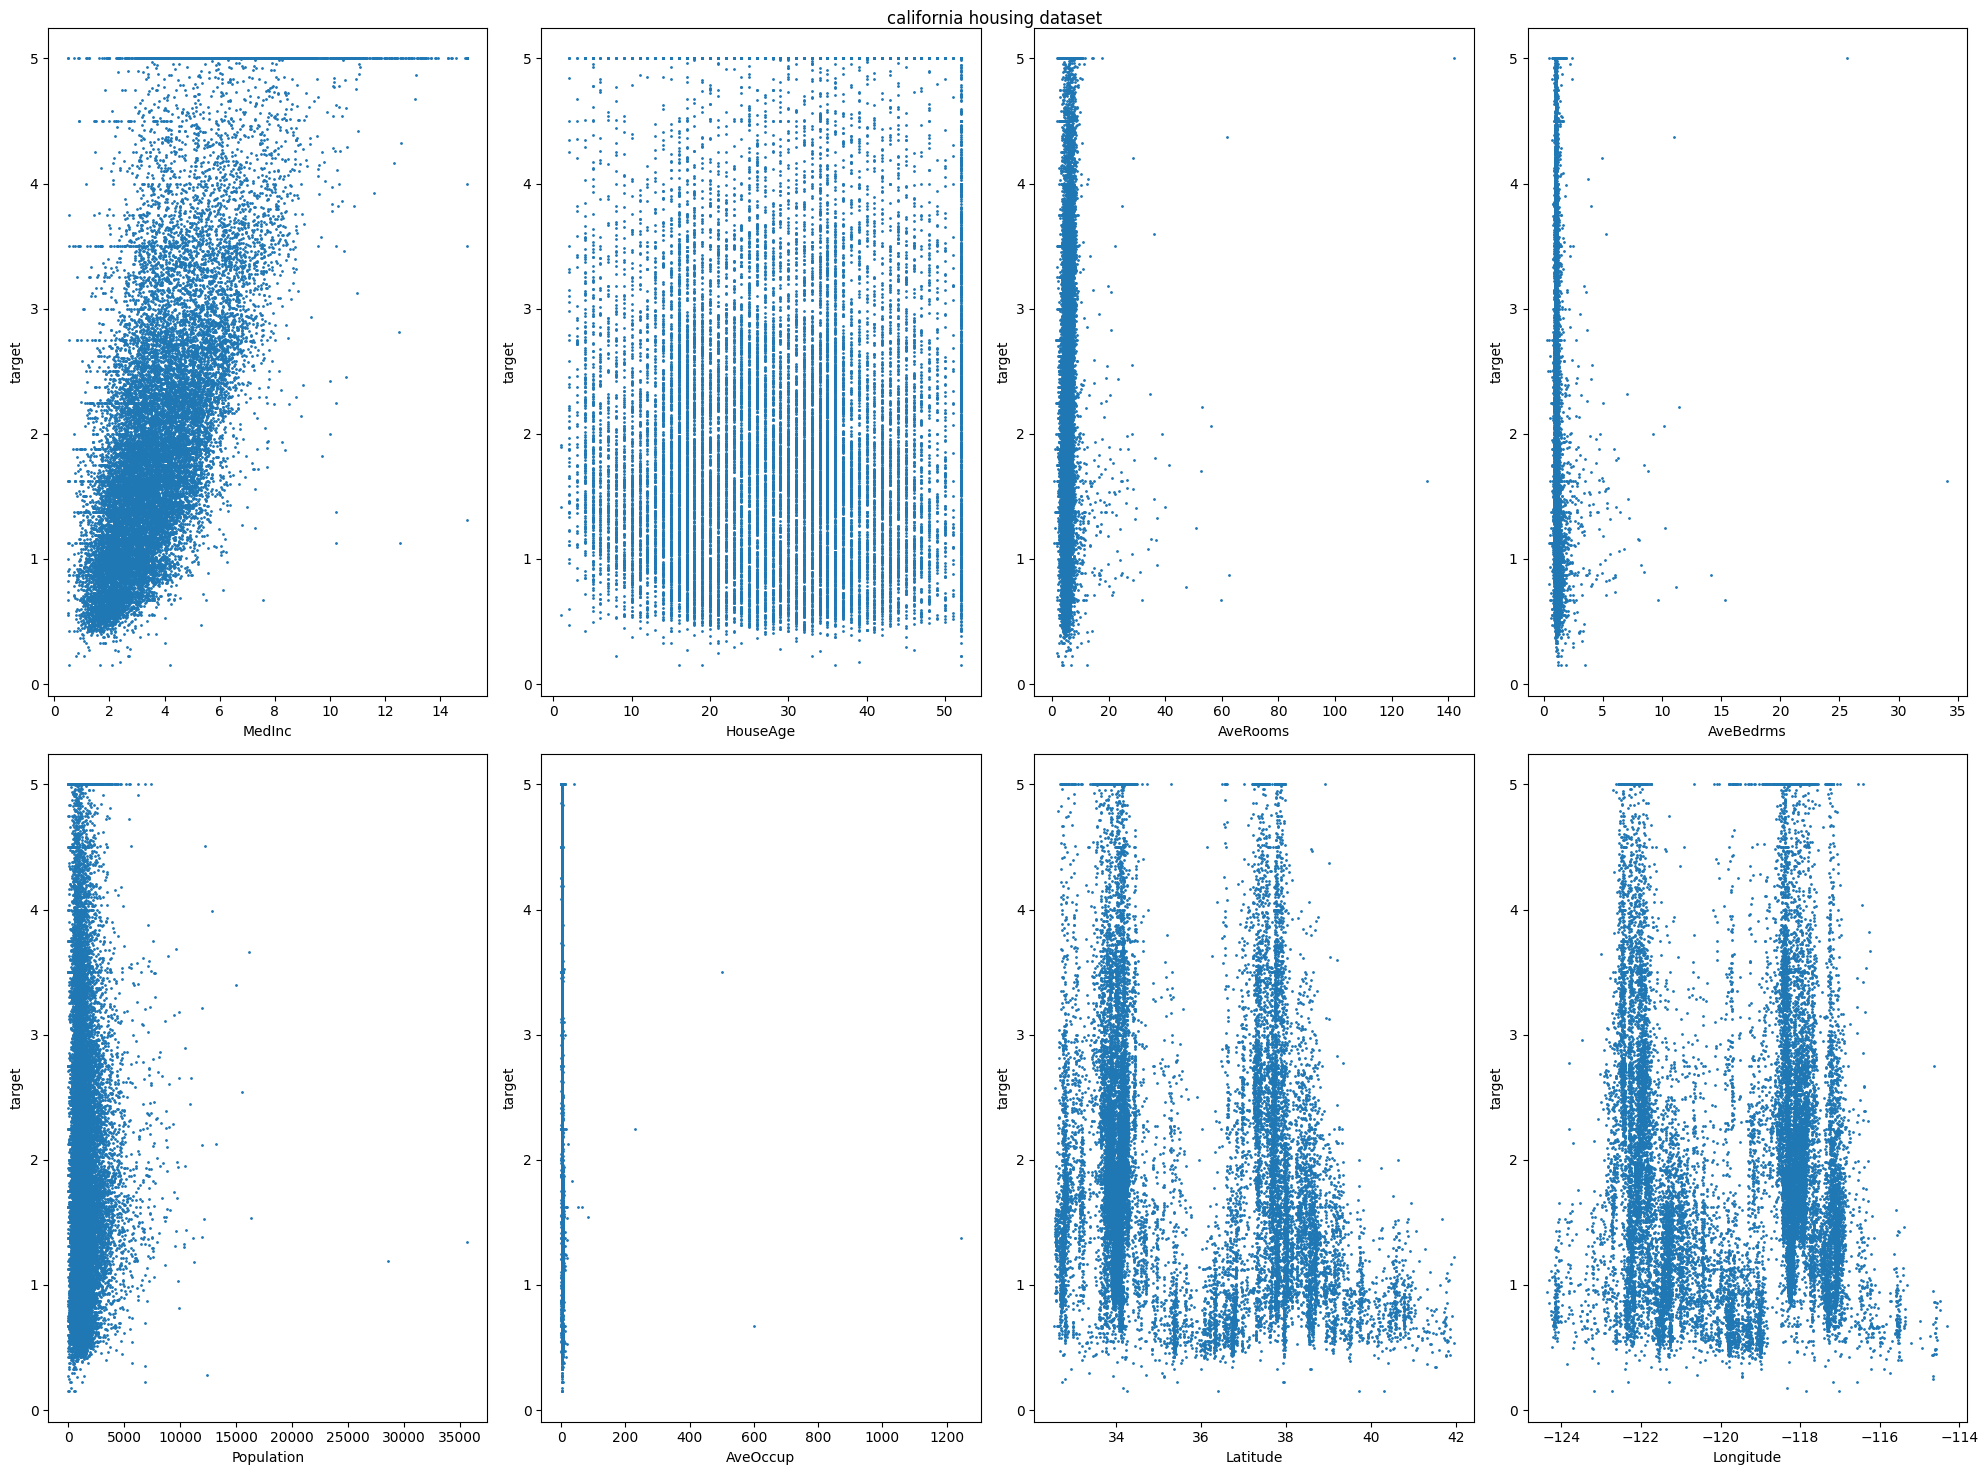

In [3]:
data = fetch_california_housing()
X, y = data.data, data.target

fig, axs=plt.subplots(2,4,figsize=(20, 15))
fig.suptitle("california housing dataset")
for i in range(2):
    for j in range(4):
        n=j+i*4
        ft=data.feature_names[n]
        axs[i,j].scatter(X[:,n],y,s=1)
        axs[i,j].set_xlabel(ft)
        axs[i,j].set_ylabel("target")

plt.tight_layout()
plt.savefig('datasetvis',dpi=300)
plt.show()

In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
###################
print("Before Normalization")
#for i in range(5):
#    print(f"features: {X_train[i].tolist()},label: {y_train[i].item()}")
X_train_df = pd.DataFrame(X_train, columns=data.feature_names)
X_train_df['Target'] = y_train
print(X_train_df.head())
########################
# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train= scaler.fit_transform(y_train.reshape(-1,1))
y_test=scaler.fit_transform(y_test.reshape(-1,1))
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
#######################################
print("\n\nAfter Normalization")
X_train_df = pd.DataFrame(X_train.numpy(), columns=data.feature_names)
X_train_df['Target'] = y_train.numpy()

# Print first few rows
print(X_train_df.head())
##############################

Before Normalization
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  3.2596      33.0  5.017657   1.006421      2300.0  3.691814     32.71   
1  3.8125      49.0  4.473545   1.041005      1314.0  1.738095     33.77   
2  4.1563       4.0  5.645833   0.985119       915.0  2.723214     34.66   
3  1.9425      36.0  4.002817   1.033803      1418.0  3.994366     32.69   
4  3.5542      43.0  6.268421   1.134211       874.0  2.300000     36.78   

   Longitude  Target  
0    -117.03   1.030  
1    -118.16   3.821  
2    -120.48   1.726  
3    -117.11   0.934  
4    -119.80   0.965  


After Normalization
     MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0 -0.326196  0.348490 -0.174916  -0.208365    0.768276  0.051376 -1.372811   
1 -0.035843  1.618118 -0.402835  -0.128530   -0.098901 -0.117362 -0.876696   
2  0.144701 -1.952710  0.088216  -0.257538   -0.449818 -0.032280 -0.460146   
3 -1.017864  0.586545 -0.600015  -0.145156   -0.00

In [5]:
#define dataloader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
# Define optimizers
def get_optimizer(optimizer_name, model):
    if optimizer_name == 'mBGD':
        return optim.SGD(model.parameters(), lr=0.001)
    elif optimizer_name == 'Momentum':
        return optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name == 'NAG':
        return optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
    elif optimizer_name == 'Adagrad':
        return optim.Adagrad(model.parameters(), lr=0.001)
    elif optimizer_name == 'RMSProp':
        return optim.RMSprop(model.parameters(), lr=0.001)
    elif optimizer_name == 'Adam':
        return optim.Adam(model.parameters(), lr=0.001)
    else:
        raise ValueError("Unsupported optimizer!")

In [6]:

dict_Tloss = {}
dict_Vloss= {}
dict_Tt={}


In [7]:
#from sklearn.metrics import r2_score

n_epochs=100
optimizers = ['mBGD', 'Momentum', 'NAG', 'Adagrad', 'RMSProp', 'Adam']
for opt_name in optimizers:
    print(f"Training with {opt_name} optimizer...")
    torch.manual_seed(42)
    # Initialize model and optimizer
    model = ANNModel(X_train.shape[1])
    optimizer = get_optimizer(opt_name, model)
    criterion = nn.MSELoss()
    
    # Training loop
    tt=[]
    losses = []
    vlosses=[]
    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_start_time = time.time()
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            epoch_loss += loss.item()
        epoch_time = time.time() - epoch_start_time
        #print(epoch_time)
        tt.append(epoch_time)
        losses.append(epoch_loss / len(train_loader))
        if epoch%10 == 0:
            print(f"epoch={epoch} : loss = {epoch_loss / len(train_loader):.4f}")

        model.eval()
        with torch.no_grad():
            vloss=0
            pred=model(X_test)
            vloss = criterion(pred, y_test)
            vlosses.append(vloss.item())
            """y_=pred.numpy()
            y=y_test.numpy()
            r2s = r2_score(y, y_)
            print(f"R² Score: {r2s:.4f}")"""
    dict_Tloss[opt_name] = losses
    dict_Vloss[opt_name] = vlosses
    dict_Tt[opt_name]=tt

Training with mBGD optimizer...
epoch=0 : loss = 0.9474
epoch=10 : loss = 0.3562
epoch=20 : loss = 0.3189
epoch=30 : loss = 0.3002
epoch=40 : loss = 0.2864
epoch=50 : loss = 0.2748
epoch=60 : loss = 0.2640
epoch=70 : loss = 0.2540
epoch=80 : loss = 0.2454
epoch=90 : loss = 0.2381
Training with Momentum optimizer...
epoch=0 : loss = 0.5376
epoch=10 : loss = 0.2464
epoch=20 : loss = 0.2201
epoch=30 : loss = 0.2050
epoch=40 : loss = 0.1996
epoch=50 : loss = 0.1949
epoch=60 : loss = 0.1895
epoch=70 : loss = 0.1861
epoch=80 : loss = 0.1824
epoch=90 : loss = 0.1766
Training with NAG optimizer...
epoch=0 : loss = 0.5354
epoch=10 : loss = 0.2443
epoch=20 : loss = 0.2170
epoch=30 : loss = 0.2048
epoch=40 : loss = 0.1979
epoch=50 : loss = 0.1927
epoch=60 : loss = 0.1878
epoch=70 : loss = 0.1835
epoch=80 : loss = 0.1798
epoch=90 : loss = 0.1754
Training with Adagrad optimizer...
epoch=0 : loss = 0.4285
epoch=10 : loss = 0.2955
epoch=20 : loss = 0.2786
epoch=30 : loss = 0.2675
epoch=40 : loss = 0.

In [8]:

for name in dict_Tt:
    print(f"optimizer: {name} total training time: {sum(dict_Tt[name]):.3f}sec average time per epoch: {sum(dict_Tt[name])/n_epochs:.3f}sec min train loss: {min(dict_Tloss[name]):.3f} min val loss: {min(dict_Vloss[name]):.3f}")

optimizer: mBGD total training time: 51.978sec average time per epoch: 0.520sec min train loss: 0.232 min val loss: 0.249
optimizer: Momentum total training time: 57.100sec average time per epoch: 0.571sec min train loss: 0.174 min val loss: 0.203
optimizer: NAG total training time: 60.363sec average time per epoch: 0.604sec min train loss: 0.172 min val loss: 0.202
optimizer: Adagrad total training time: 86.336sec average time per epoch: 0.863sec min train loss: 0.233 min val loss: 0.254
optimizer: RMSProp total training time: 89.664sec average time per epoch: 0.897sec min train loss: 0.085 min val loss: 0.195
optimizer: Adam total training time: 117.764sec average time per epoch: 1.178sec min train loss: 0.084 min val loss: 0.191


In [9]:
#print(dict_Tloss[opt_name][3])
print(dict_Tloss)

{'mBGD': [0.9268657219444596, 0.7160566977636759, 0.5403329416705195, 0.46913155552375224, 0.4453371313884277, 0.4304505683654963, 0.4180773151244304, 0.4073502682726975, 0.39774644533677617, 0.3891927030861609, 0.3815132587743822, 0.3744765846708486, 0.3685125425284685, 0.3628338628787865, 0.35780587883362935, 0.3532744384146938, 0.349181120262243, 0.34533105275138865, 0.3419858198468537, 0.3387218162041995, 0.3355607338567344, 0.3327913373824238, 0.33020026661282365, 0.32750415004963096, 0.32548561601271464, 0.3231823189516169, 0.3211082755046528, 0.3191112991162511, 0.3174722003786601, 0.315742379299892, 0.3141030576224475, 0.3126865793597098, 0.3114114295864521, 0.3098300568355146, 0.3086350268229496, 0.3076160098462142, 0.30635297129493816, 0.3052691758083281, 0.3040225101678177, 0.3031180368433165, 0.30184571486861667, 0.3010828997651043, 0.29993332051780336, 0.2988368062114762, 0.29796418858071166, 0.29704241341976234, 0.29623185033195243, 0.2951827728471091, 0.29447164649302643

In [9]:
a=list(range(1,n_epochs+1))
print(a)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


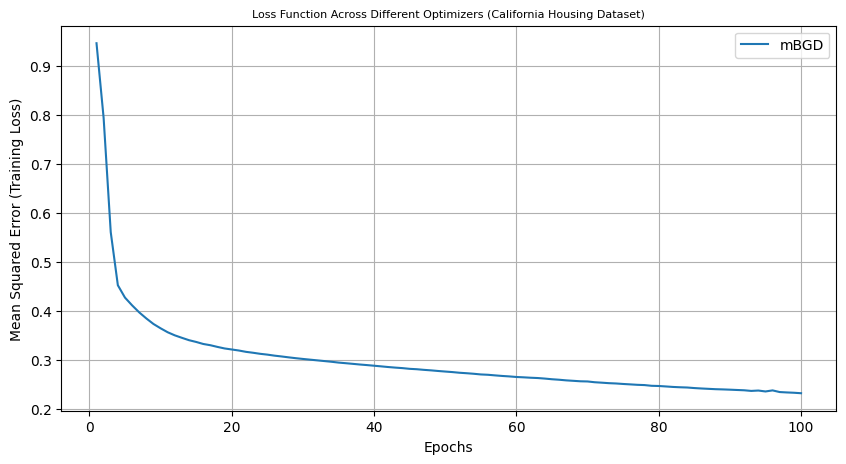

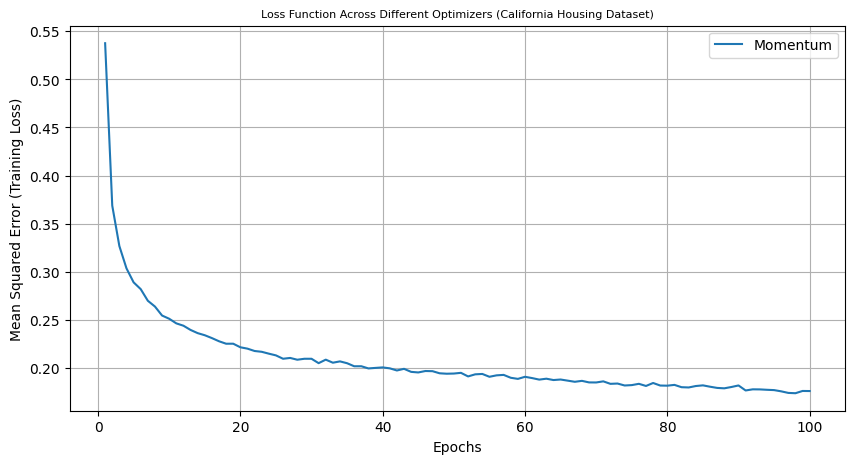

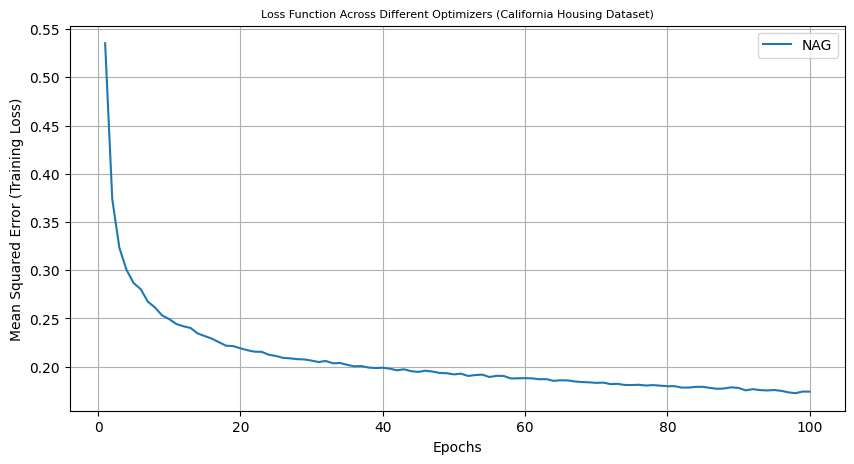

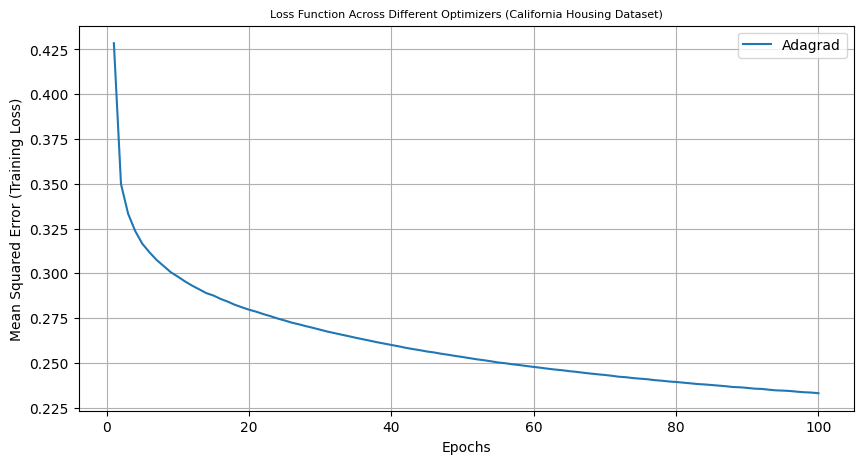

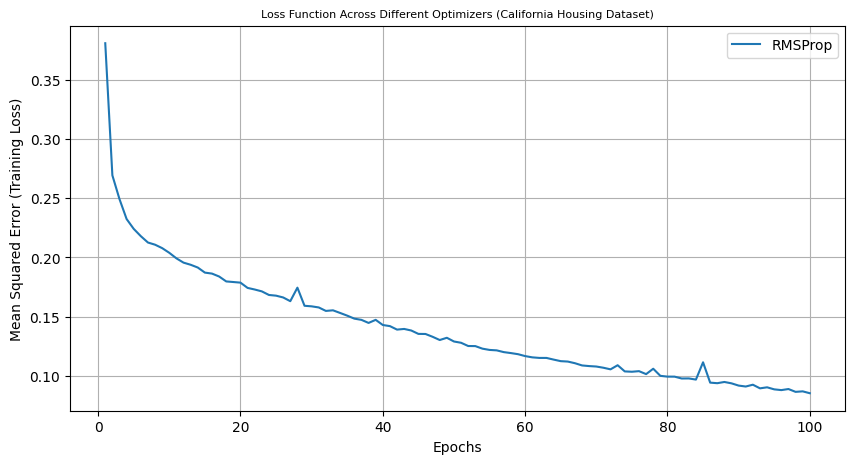

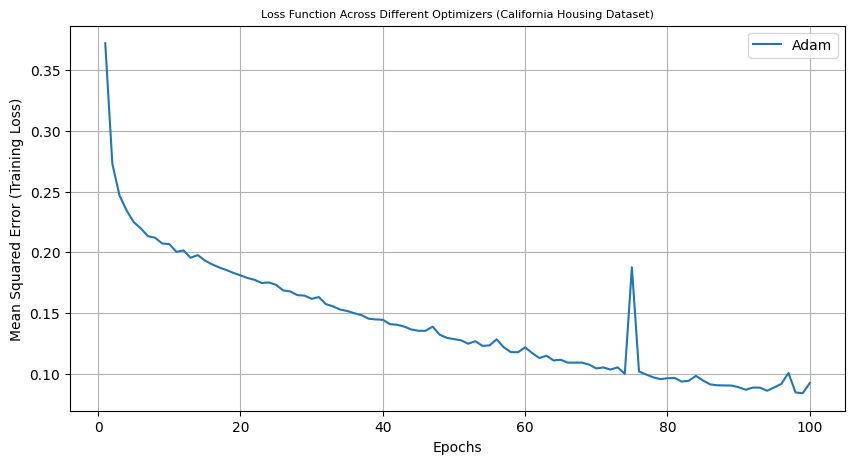

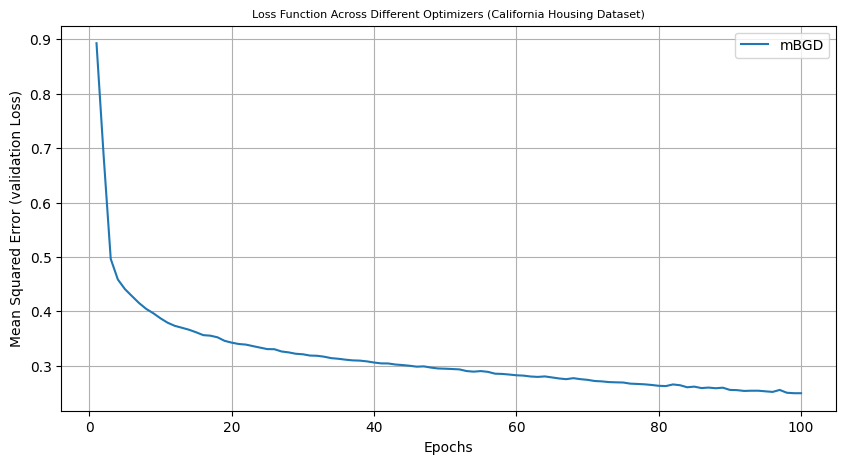

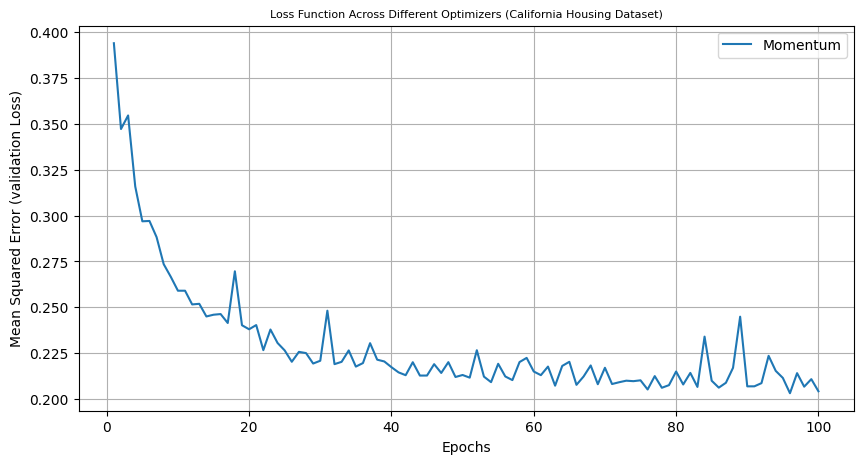

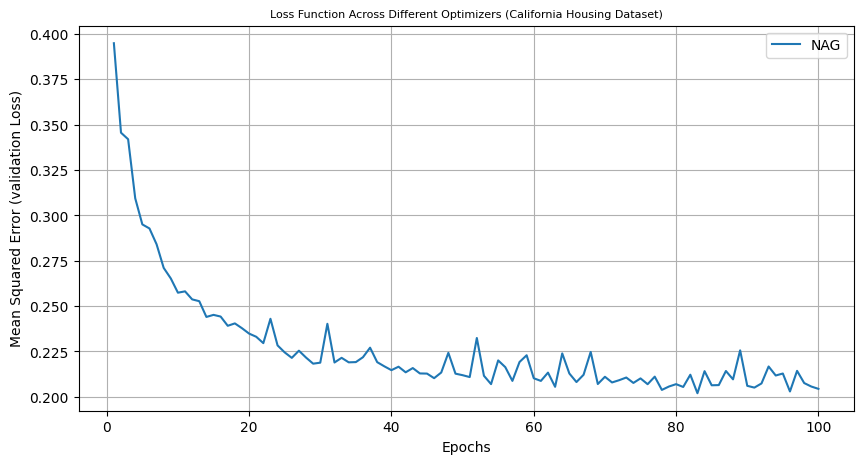

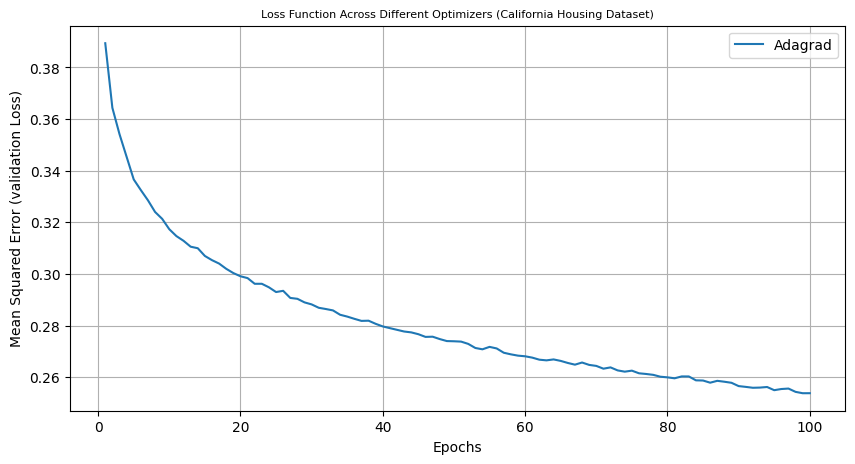

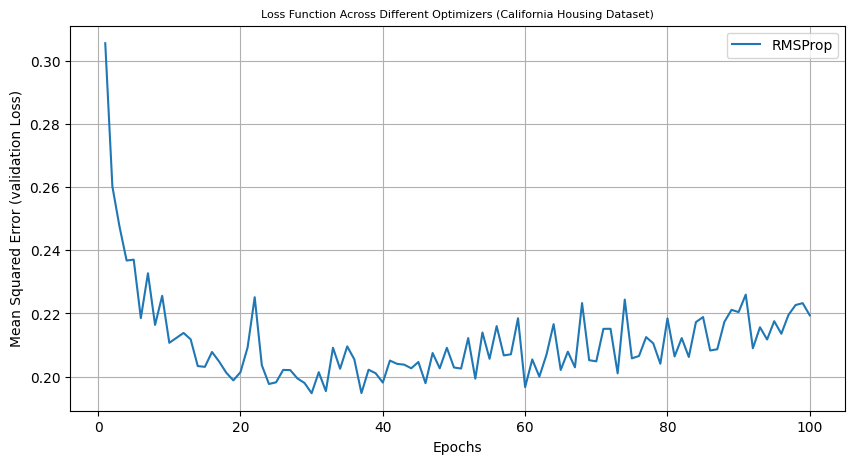

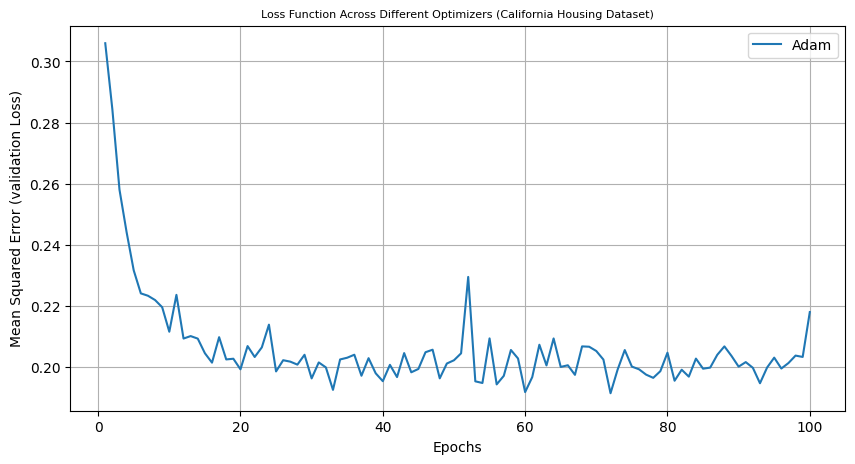

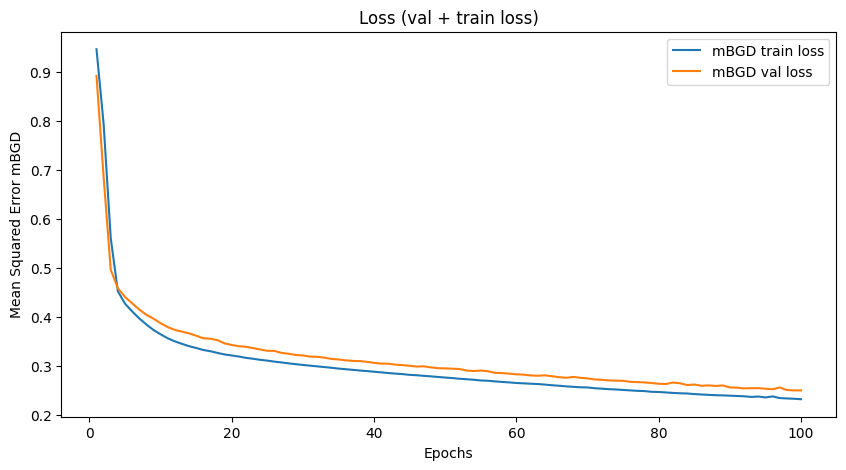

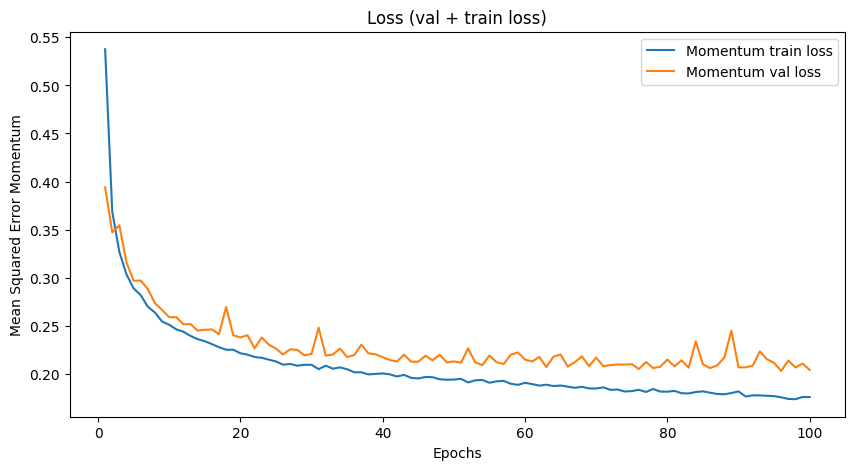

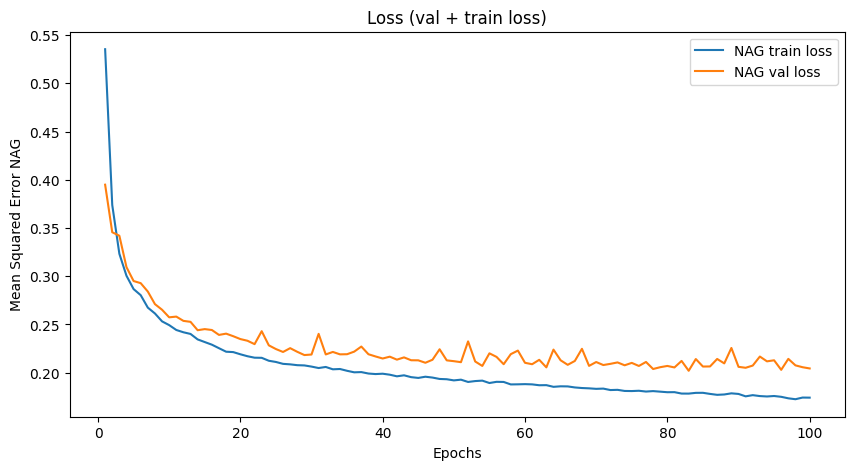

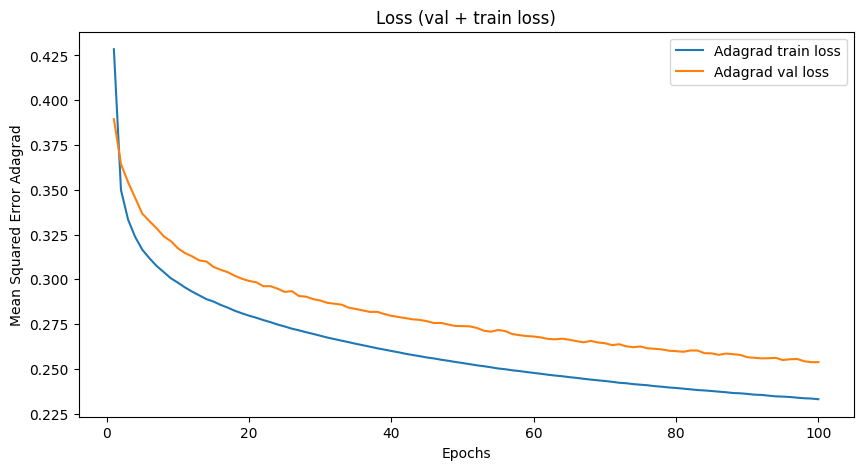

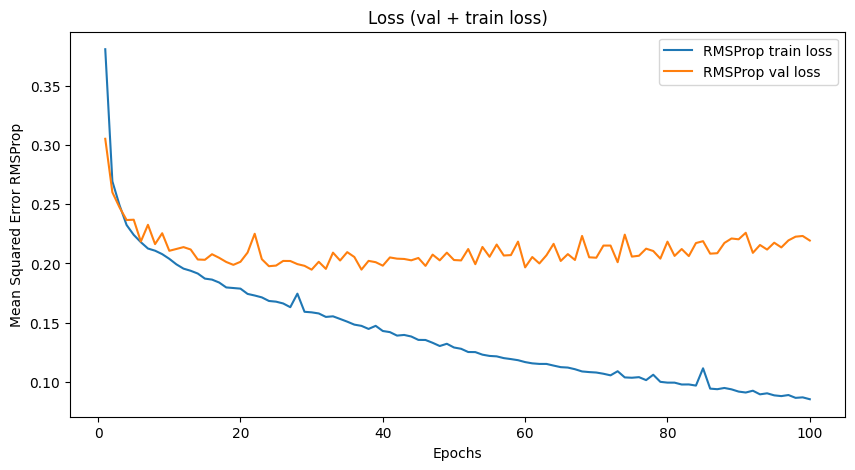

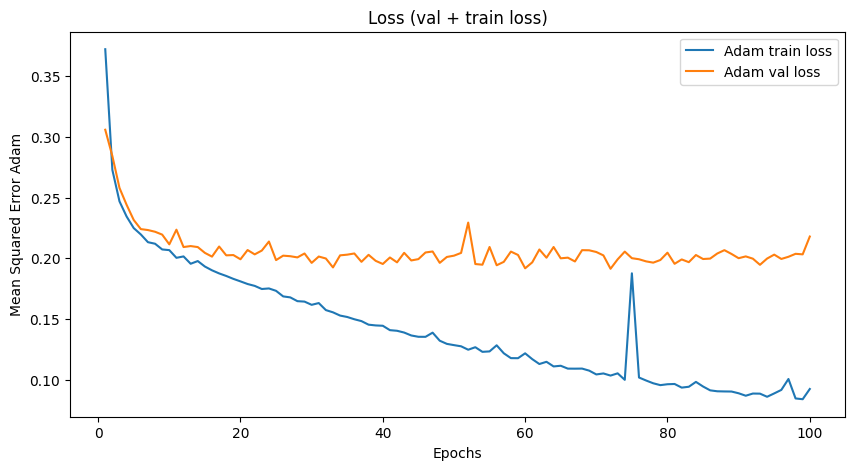

In [10]:
for name, loss in dict_Tloss.items():
    plt.figure(figsize=(10, 5))
    plt.title('Loss Function Across Different Optimizers (California Housing Dataset)',fontsize=8)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (Training Loss)')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
    #for c, d in zip(a, loss):
        #plt.annotate(text=f"{d:.3f}",xy=(c, d),fontsize=5)
    plt.savefig(f'Training loss {name}.png',dpi=500)
    plt.show()


for name, loss in dict_Vloss.items():
    plt.figure(figsize=(10, 5))
    plt.title('Loss Function Across Different Optimizers (California Housing Dataset)',fontsize=8)
    plt.xlabel('Epochs')
    plt.ylabel(f'Mean Squared Error (validation Loss)')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
#    for c, d in zip(a, loss):
#        plt.annotate(text=f"({d:.3f})",xy=(c, d),fontsize=6)
    plt.savefig(f'validation loss {name}.png',dpi=500)
    plt.show()
    
for name in dict_Vloss.keys():
    plt.figure(figsize=(10, 5))
    plt.title('Loss (val + train loss)')
    plt.xlabel('Epochs')
    plt.ylabel(f'Mean Squared Error {name}')
    plt.plot(a,dict_Tloss[name],label=name+' train loss')
    plt.plot(a,dict_Vloss[name],label=name+" val loss")
    plt.legend()
    plt.savefig(f'combined train and val {name}.png',dpi=500)
    plt.show()




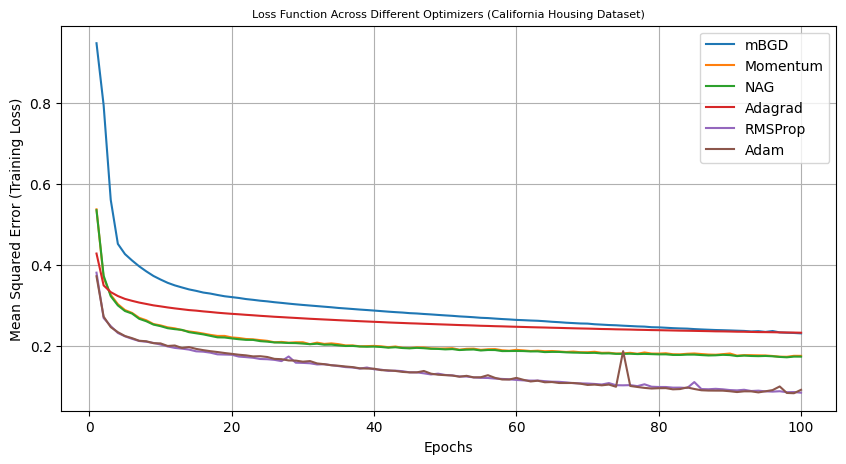

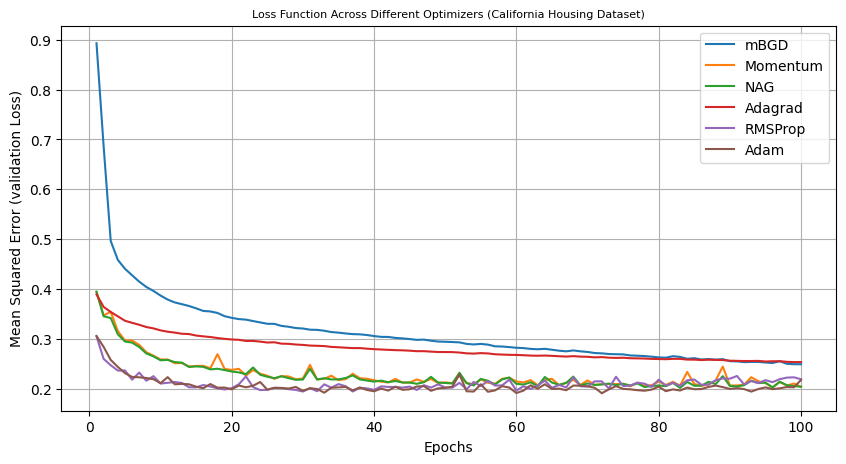

In [11]:
plt.figure(figsize=(10, 5))
for name, loss in dict_Tloss.items():
    plt.title('Loss Function Across Different Optimizers (California Housing Dataset)',fontsize=8)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (Training Loss)')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
plt.savefig(f'combined training loss all.png',dpi=500)
plt.show()

plt.figure(figsize=(10, 5))
for name, loss in dict_Vloss.items():
    plt.title('Loss Function Across Different Optimizers (California Housing Dataset)',fontsize=8)
    plt.xlabel('Epochs')
    plt.ylabel(f'Mean Squared Error (validation Loss)')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
plt.savefig(f'combined validation loss all.png',dpi=500)
plt.show()

In [12]:

geeky_file = open('TrainingResults.txt', 'wt') 
geeky_file.write("train loss\n "+str(dict_Tloss)+"\nvalidation loss\n "+str(dict_Vloss)+"\n time\n "+str(dict_Tt)) 
geeky_file.close()